# Dual beam zoneplate simulations
awojdyla@lbl.gov, March 2024

In this notebook, we show how to generate a zoneplate by wrapping and thresholding the phase of a lens, and how to create a double focus by using an XOR operation between the zones and a grating, in order to suppress focusing in the zero order.

## Define the zoneplate

These are the design paramaters of the dual beam zoneplate made by CXRO in 2029:
* numerical aperture: 0.01NA
* focal distance: 12mm
* central stop: 95um
* spot size: 110nm
* spot separation: 10um
* design photon energy: 700 eV

Other parameters and constraints for manufacturing
* 85nm outer ring radius (corrected for 700eV)
* Diameter 240 microns (fit the ebeam lithography machine )
* Au 200nm thick zones (3% transmission at 700eV, may be
thicker)

In [17]:
import numpy as np
import matplotlib.pyplot as plt  

# monoplus is a wavefront propagation package that was implemented by Paola Luna (SULI student at Berkeley Lab at the time.)
# base repo (private): https://github.com/paola-luna24/Monoplus-project
# available here: https://github.com/awojdyla/Monoplus-project
# The repo is not well documented, something we need to work on
# importing functions manually so that we can import them from another package later
from monoplus import divg, focus, fwhm, gaussfunc, polyfunc, propHF, propTF, secondmomt

In [18]:
# Zoneplate design paramaters
focal_m = 12e-3 #focal distance
spot_sep_m = 10e-6 # spot seperation 
diameter_m = 240e-6 # zoneplate diameter
central_m = 95e-6 # center stop
Ed_eV = 700 #  design photon energy

wavelength_m = 1234e-9/Ed_eV #hc/EV

p_m = 1e9 #object distance (infinity)
q_m = focal_m #image distance

#compute focal length (felxible, in case we want to reimage a source at finite distance)
f_m = 1/(1/p_m+1/q_m) #focal length

NA = diameter_m/focal_m/2 # numerical aperture of the zoneplate
min_dx_m = wavelength_m/NA # mininum ring size of the zone (approx)

# definition of the computation grid
Dx_m = 1e-3 # grid size
dx_m = 1e-9 # pixel size – dx needs to be bigger (~10x)than min_dx_m unless 
# another condition for propagation: dx_m<avelength_m*z_m/Dx_m

# computation grid (for Fourier method)
x_m = np.linspace(-Dx_m/2,Dx_m/2, int(Dx_m/dx_m)+1)


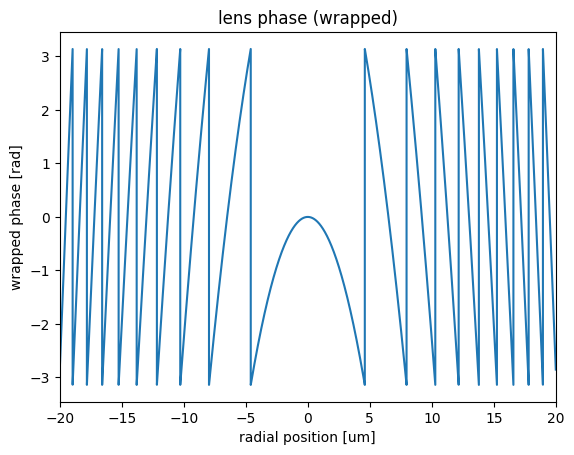

In [19]:
# Phase required for focusing (based on standard definitions in Fourier optics)
foc_phase = np.exp(-1j*2*np.pi/(wavelength_m*2*f_m)*(x_m**2))

plt.plot(x_m*1e6,np.angle(foc_phase))
plt.xlabel('radial position [um]')
plt.ylabel('wrapped phase [rad]')
plt.title('lens phase (wrapped)')
plt.xlim((-20,20))
plt.show()

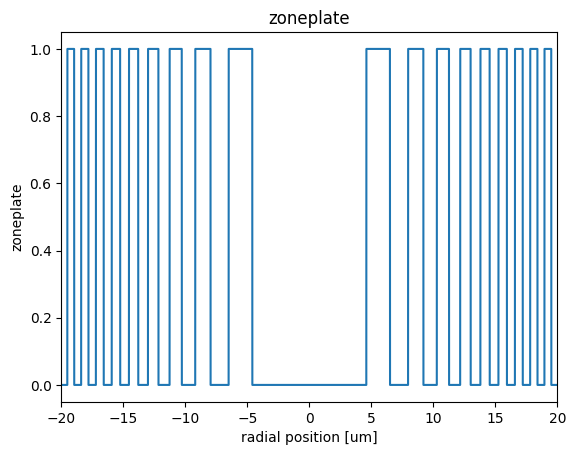

In [20]:
# thresholding of the phase to generate the zones
ZP = np.angle(foc_phase)>0 # regular zoneplate

plt.plot(x_m*1e6,ZP)
plt.xlabel('radial position [um]')
plt.ylabel('zoneplate')
plt.title('zoneplate')
plt.xlim((-20,20))
plt.show()


## Propagate to focus
We are testing the zoneplate by propagating it to make sure it focus where we expext it to.

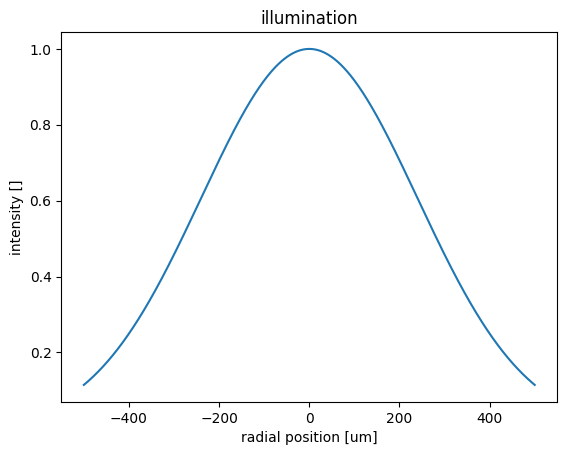

In [21]:
# define a source beam (a guassian with a FWHM the size of the zoneplate)
E0 = np.sqrt(gaussfunc(x_m,0,diameter_m)) #note: sqrt for amplitude -- FWHM is defined in intensity

plt.plot(x_m*1e6,abs(E0)**2)
plt.xlabel('radial position [um]')
plt.ylabel('intensity []')
plt.title('illumination')
plt.show()

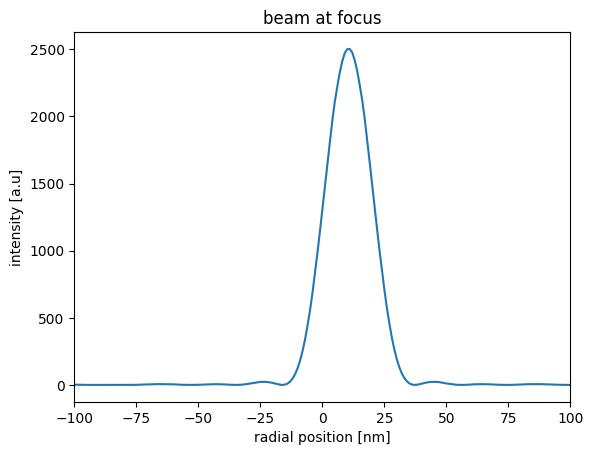

In [22]:
# propagate 
EZP = E0*ZP # multiply incident field with zoneplate
Ef = propTF(EZP,Dx_m,wavelength_m,focal_m)

plt.plot(x_m*1e9,abs(Ef)**2)
plt.xlabel('radial position [nm]')
plt.ylabel('intensity [a.u]')
plt.title('beam at focus')
plt.xlim((-100,100)) # restricting the plot to where the focus exist
plt.show()

## Dual beam zoneplate
Until now, we have defined a vanilla zoneplate.

We now want to define a dual beam zoneplate.

In [23]:
# angle separation from the underlying grating (separation = theta * distance)
theta_rad = (spot_sep_m/2)/focal_m

# underlying grating (theta = lambda/a)
period_m     = wavelength_m/theta_rad

# define the central stop since we'll remove
central_stop = abs(x_m) < central_m/2

# grating definition
grating      = (1+np.sign(np.sin(2*np.pi/period_m*x_m)))/2

# generate the Dual Beam Zoneplate using an XRO operation (and remove the central spot)
DBZ = np.logical_xor(ZP,grating)*np.logical_not(central_stop)

# it would be the following otherwise, but yield worse results:
#DZP = ZP*grating

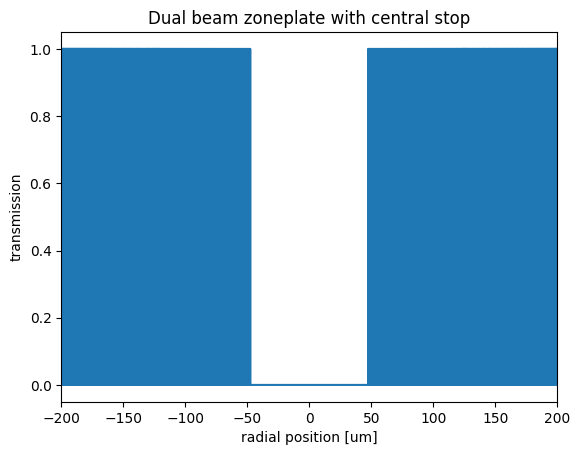

In [9]:
# check the zoneplate is properly defined
plt.plot(x_m*1e6,DBZ)
plt.xlabel('radial position [um]')
plt.ylabel('transmission')
plt.title('Dual beam zoneplate with central stop')
plt.xlim((-200,200))
plt.show()

## Propagate to focus
We should see two main spots separated by 10 um. Since the zoneplate is very fine and has many zones of size commensurate with focus, we can keep the Fourier method for propagation. Let's go!

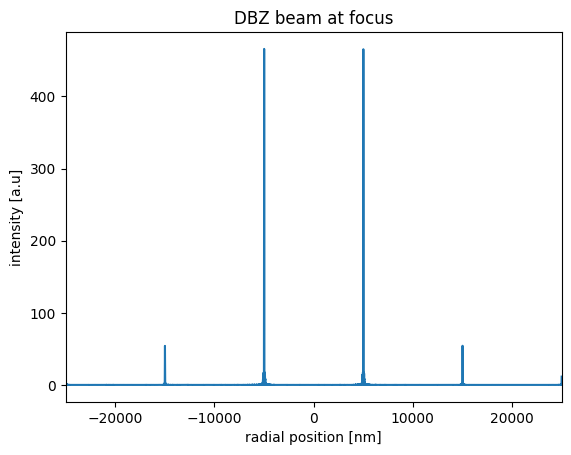

In [25]:
# propagate to focus
EDBZ = E0*DBZ
Ef_dbz = propTF(EDBZ, Dx_m, wavelength_m, focal_m)

plt.plot(x_m*1e9,abs(Ef_dbz)**2)
plt.xlabel('radial position [nm]')
plt.ylabel('intensity [a.u]')
plt.title('DBZ beam at focus')
plt.xlim((-25000,25000))

plt.show()

## Propagate in the far field
Now we want to propagate in the far field, where the beam size may easily be larger than the computing grid. Therefore, we want to use the (somewhat slower) Fresnel-Huygens method, that allows to propagate on a grid of arbitrary size.

*THIS CAN TAKE A WHILE*
e.g. 15 sec on my Mac M2 but only a single core.

We expect to see beautful fringe from Young's slits (because the focus is a coherent dual focus, acting is if there were two coherent sources)

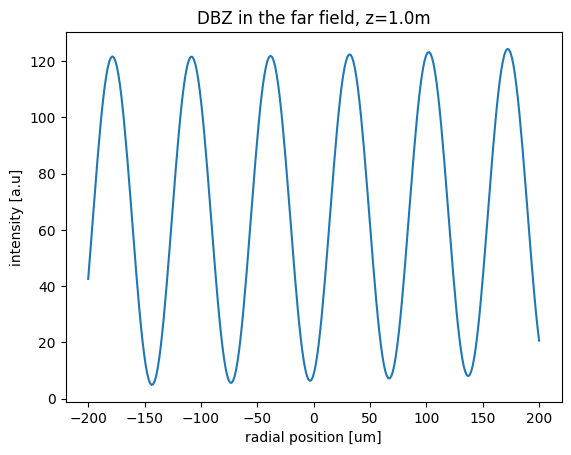

In [28]:
# need to use huygens fresnel here because
# dx_m<wavelength_m*z_m/Dx_m 

# limiting the input field (could be improved by masking around the focii) to where there is actually signal
mask_focii = abs(x_m)<2.5*spot_sep_m/2
# far field coordinate
xff_m = np.linspace(-2e-4,2e-4,300)

z_m = 1 #propagation distance
# not fast at all! ~1 sec per point
Edbz_ff = propHF(x_m[mask_focii], xff_m, Ef_dbz[mask_focii], 2*np.pi/wavelength_m, z_m)

plt.plot(xff_m*1e6,abs(Edbz_ff)**2)
plt.xlabel('radial position [um]')
plt.ylabel('intensity [a.u]')
plt.title('DBZ in the far field, z=%1.1fm'%z_m)
plt.show()

## Phase shift in the far-field

In [49]:
# need to use huygens fresnel here because
# dx_m<wavelength_m*z_m/Dx_m 

# limiting the input field (could be improved by masking around the focii) to where there is actually signal
mask_focii = abs(x_m)<2.5*spot_sep_m/2
# far field coordinate
xff_m = np.linspace(-2e-4,2e-4,300)

# we create a phase shift between the two spots
phase_shift_deg = 10
phase_mask_rad = np.exp(1j*np.pi*np.sign(x_m[mask_focii])*phase_shift_deg/360)

z_m = 1 #propagation distance
# not fast at all! ~1 sec per point
Edbz_ph_ff = propHF(x_m[mask_focii], xff_m, Ef_dbz[mask_focii]*phase_mask_rad, 2*np.pi/wavelength_m, z_m)



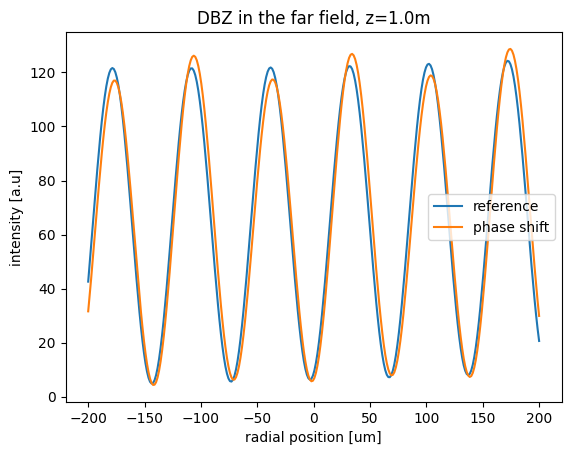

In [50]:
plt.plot(xff_m*1e6,abs(Edbz_ff)**2, xff_m*1e6,abs(Edbz_ph_ff)**2)
plt.xlabel('radial position [um]')
plt.ylabel('intensity [a.u]')
plt.legend(('reference','phase shift'))
plt.title('DBZ in the far field, z=%1.1fm'%z_m)
plt.show()